In [1]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.gridspec as gridspec
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from scipy.stats import pearsonr
import utils_results as ut
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
def crop_field(var, lon1, lon2, lat1, lat2):
    """
    Crop the specified variable to the specified domain.

    Inputs:
        var: xarray.DataArray or xarray.Dataset
            The variable to crop
        lon1: float
            The western longitude of the domain (range: -180 to 180)
        lon2: float
            The eastern longitude of the domain (range: -180 to 180)
        lat1: float
            The southern latitude of the domain
        lat2: float
            The northern latitude of the domain
    Outputs:
        ds: xarray.DataArray or xarray.Dataset
            The cropped variable
    """
    ds = var.copy()
    # If the domain crosses/touches the meridian 180, convert to 0-360
    if (lon1 <= 180 and lon2 >= -180 and lon1 > lon2) or (lon1 == -180) or (lon2 == 180):
        ds.coords['longitude'] = (ds.longitude + 360) %360
        ds = ds.sortby(ds.longitude)
        if lon2 < 0:
            lon2 = lon2 + 360
        if lon1 < 0:
            lon1 = lon1 + 360
    return ds.sel(longitude=slice(lon1, lon2), latitude=slice(lat2, lat1))

def check_consecutive_repeats(df,col):
    repeats = df.shift(1) == df
    if repeats.sum() > 0:
        print('Consecutive values repeated found at',col)
        print(repeats[repeats].index)

def build_dataset(basin, cluster_variables, index_variables, cluster_path, indexes_path, target_path, first_year, last_year, month_col=True):
    
    # Define geographical coordinates according to the basin considered
    if basin == 'NWP':
        min_lon, max_lon, min_lat, max_lat = 100, 180, 0, 40
    elif basin == 'NEP':
        min_lon, max_lon, min_lat, max_lat = -180, -75, 0, 40
    elif basin == 'NA':
        min_lon, max_lon, min_lat, max_lat = -100, 0, 0, 40
    elif basin == 'NI':
        min_lon, max_lon, min_lat, max_lat = 45, 100, 0, 40
    elif basin == 'SP':
        min_lon, max_lon, min_lat, max_lat = 135, -70, -40, 0
    elif basin == 'SI':
        min_lon, max_lon, min_lat, max_lat = 35, 135, -40, 0
    elif basin == 'GLB':
        min_lon, max_lon, min_lat, max_lat = -181, 181, -40, 40
    else:
        raise ValueError('Basin not recognized')

    # Create a dataframe containing the data for the climate indeces
    date_range = pd.date_range(start=f'{first_year}-01-01', end=f'{last_year}-12-01', freq='MS')
    df_indeces = pd.DataFrame(index=date_range, columns=index_variables)
    for climate_index in index_variables:
        filename = os.path.join(indexes_path, climate_index + '.txt')
        data = pd.read_table(filename, sep='\s+', header=None)
        for r, row in enumerate(df_indeces.iterrows()):
            idx = df_indeces.index[r]
            month = idx.month
            year = idx.year
            df_indeces.loc[idx, climate_index] = data[(data[0] == year)][month].values[0]

    # Load the cluster data and merge it in a single dataframe
    for v, var in enumerate(cluster_variables):
        filename = f'averages_{var}.csv'
        path = os.path.join(cluster_path, filename)
        if v == 0:
            dataset_cluster = pd.read_csv(path, index_col=0, parse_dates=True)
        else:
            dataset_cluster = pd.concat([dataset_cluster, pd.read_csv(path, index_col=0, parse_dates=True)], axis=1)

    # Merge the cluster and index dataframes
    dataset = pd.concat([dataset_cluster, df_indeces], axis=1)

    # Add a column containing the month of the year
    if month_col:
        dataset['month'] = dataset.index.month
    
    # Check if any data is missing, repeated in consecutive days, or is above the average+7*std
    for col in dataset.columns:
        if dataset[col].isnull().sum() > 0:
            print('Warning: Missing values in', col)
        check_consecutive_repeats(dataset[col],col)
        mean = dataset[col].mean()
        std = dataset[col].std()
        if (np.abs(dataset[col]) > mean + 7*std).sum() > 0:
            print('Warning: Values above the average+7*std in', col)

    # Build the dataframe for the target variable -> number of tropical cyclone genesis events per month
    years = np.arange(first_year, last_year+1, 1)
    tcg_ds_or = xr.concat([xr.open_dataset(target_path + f'_{year}.nc') for year in years], dim='time')
    if basin == 'NEP' or basin == 'NA':
        tcg_ds = crop_field(tcg_ds_or, min_lon, max_lon, min_lat, max_lat)
        mask = xr.open_dataarray(f'{basin}_mask.nc')
        tcg_ds = tcg_ds.where(mask == 1)
    elif basin != 'GLB':
        tcg_ds = crop_field(tcg_ds_or, min_lon, max_lon, min_lat, max_lat)
    else:
        tcg_ds = tcg_ds_or
    target = pd.DataFrame(index=date_range)
    target['tcg'] = tcg_ds.tcg.sum(dim=['latitude', 'longitude']).values.astype(int)

    return dataset, target

In [20]:
basin = 'GLB'
n_clusters = 8
anomaly_clustering = 'y'
res = 2.5
first_year = 1975
last_year = 2022

# List of variables to include for the feature selection process
cluster_variables = ['abs_vo850', 'mpi', 'msl', 'r700', 'sst', 'vo850', 'vws850-200', 'w']
climate_indexes = ['EA-WR', 'ENSO3.4', 'NAO', 'PDO', 'PNA', 'SOI', 'TNA', 'TSA', 'WP'] # EP-NP is equal to -99.9 on december

# Directories to consider to build the dataset for feature selection
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
if anomaly_clustering == 'y':
    cluster_path = os.path.join(project_dir, 'FS_TCG', 'data', f'{basin}_{n_clusters}clusters_anomaly')
else:
    cluster_path = os.path.join(project_dir, 'FS_TCG', 'data', f'{basin}_{n_clusters}clusters')
indexes_path = os.path.join(project_dir, 'data', 'CI')
resolution = '{}x{}'.format(res, res)
target_path = os.path.join(project_dir, 'data', 'IBTrACS', resolution, 'TCG', f'TCG_{resolution}')
# Folder to save the dataset
save_path = cluster_path

# Build the dataset and save it to file
dataset, target = build_dataset(basin, cluster_variables, climate_indexes, cluster_path, indexes_path, target_path, first_year, last_year, month_col=True)


Consecutive values repeated found at ENSO3.4
DatetimeIndex(['1981-03-01', '1988-07-01', '1990-05-01', '1990-09-01',
               '1996-02-01', '1996-07-01', '1998-11-01', '1999-01-01',
               '2013-04-01', '2016-09-01', '2018-01-01', '2018-11-01',
               '2019-12-01', '2021-02-01', '2021-11-01', '2022-05-01'],
              dtype='datetime64[ns]', freq=None)
Consecutive values repeated found at NAO
DatetimeIndex(['2001-08-01'], dtype='datetime64[ns]', freq='MS')
Consecutive values repeated found at PDO
DatetimeIndex(['1986-09-01', '1986-12-01', '1990-06-01', '1992-11-01',
               '2001-10-01', '2018-05-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq=None)
Consecutive values repeated found at PNA
DatetimeIndex(['1980-07-01', '2008-09-01', '2010-09-01'], dtype='datetime64[ns]', freq=None)
Consecutive values repeated found at SOI
DatetimeIndex(['1977-09-01', '1980-06-01', '1982-0

Text(0.5, 1.0, 'GLB cyclogenesis events residual')

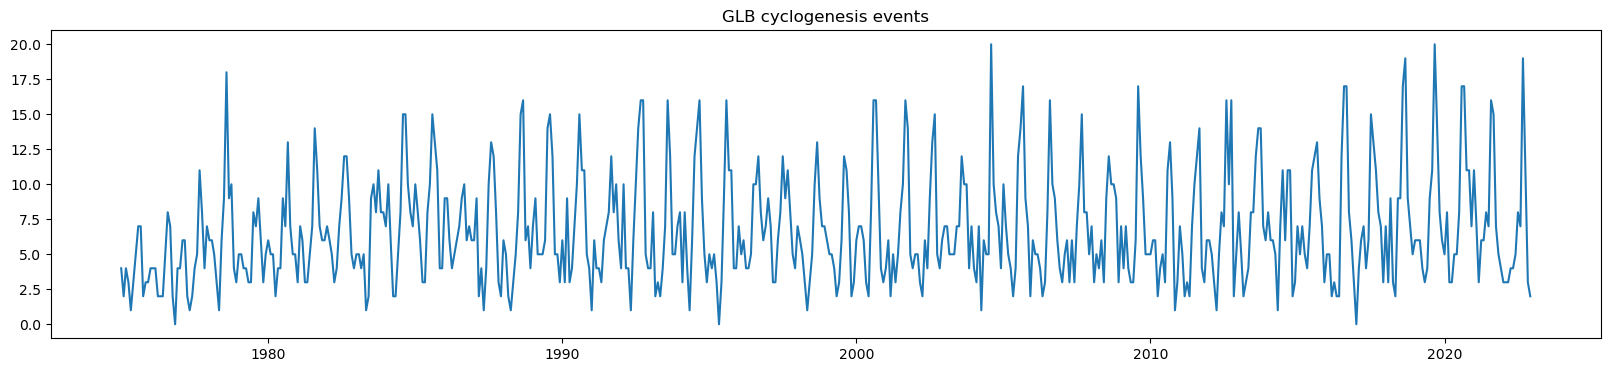

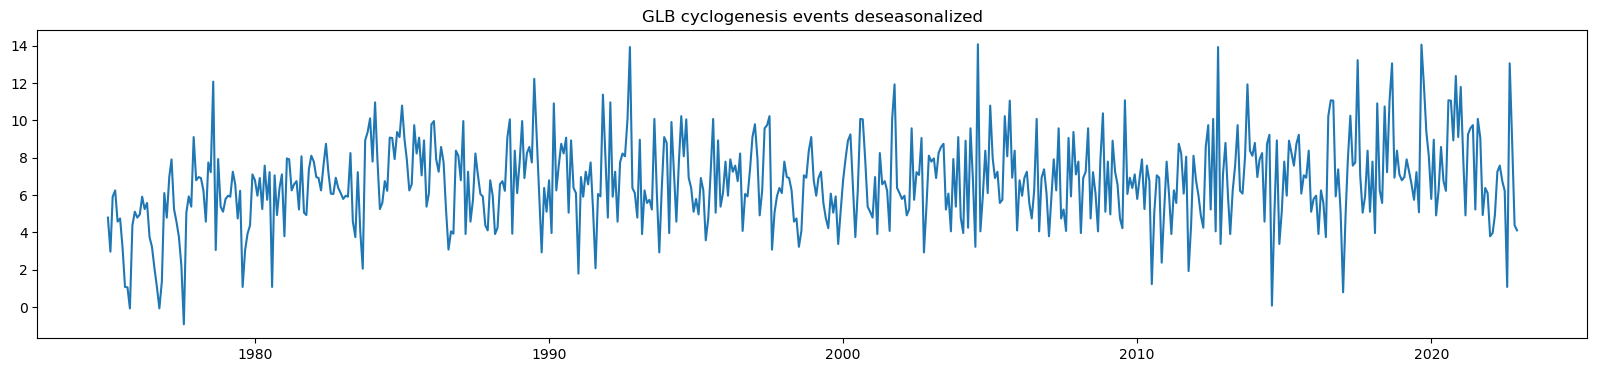

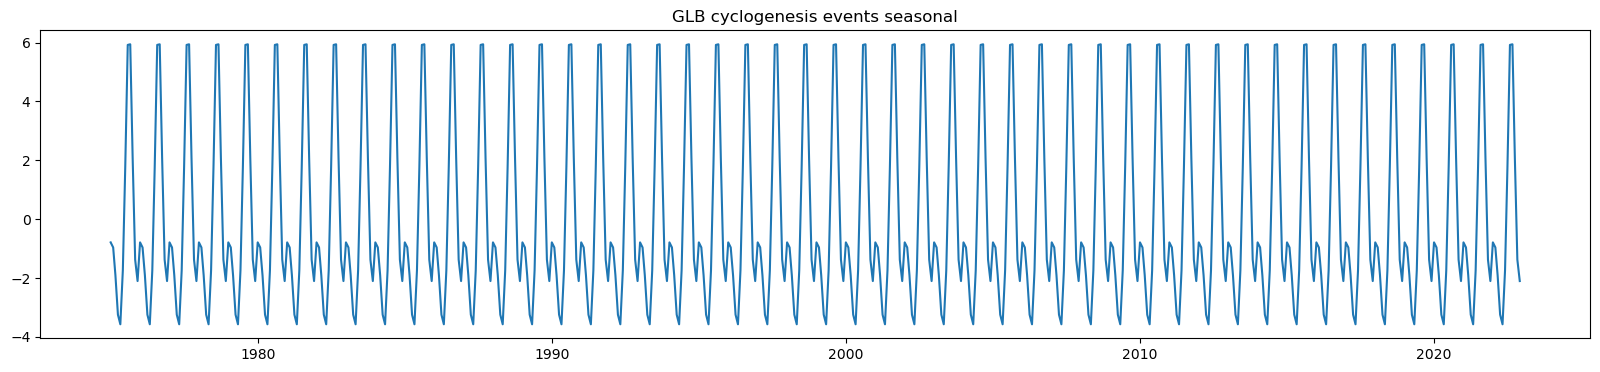

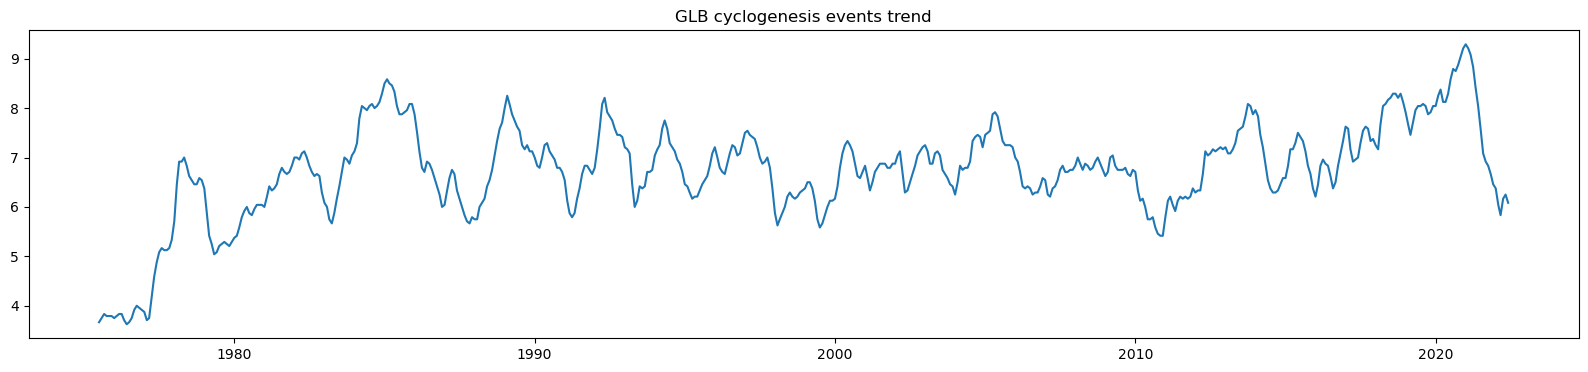

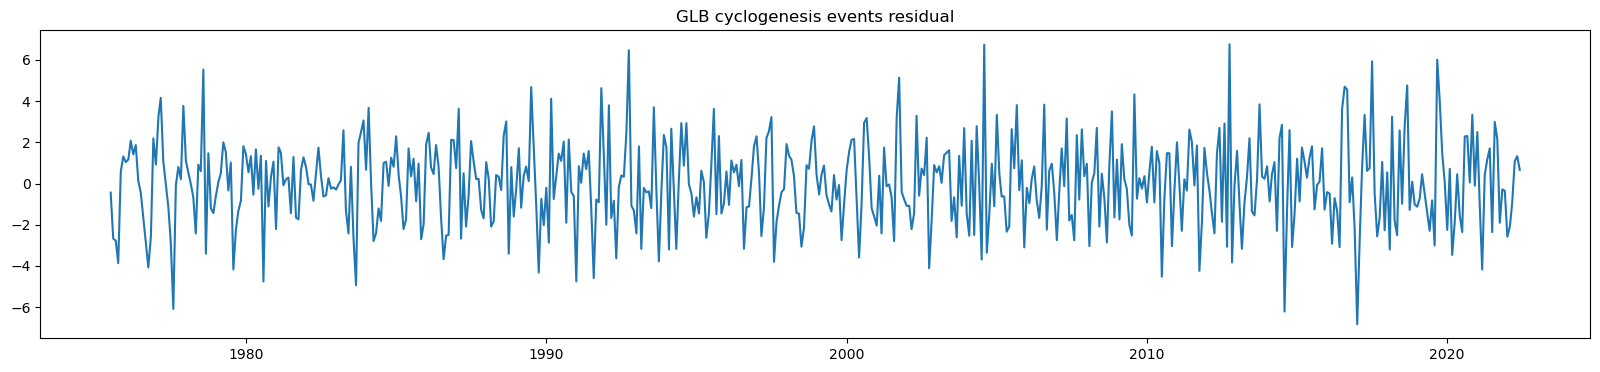

In [22]:
plt.figure(figsize=(20, 4))
plt.plot(target['tcg'])
plt.title(f'{basin} cyclogenesis events')
decomposition = seasonal_decompose(target['tcg'], model='additive')
deseason_target = target['tcg'] - decomposition.seasonal
plt.figure(figsize=(20, 4))
plt.plot(deseason_target)
plt.title(f'{basin} cyclogenesis events deseasonalized')
plt.figure(figsize=(20, 4))
plt.plot(decomposition.seasonal)
plt.title(f'{basin} cyclogenesis events seasonal')
plt.figure(figsize=(20, 4))
plt.plot(decomposition.trend)
plt.title(f'{basin} cyclogenesis events trend')
plt.figure(figsize=(20, 4))
plt.plot(decomposition.resid)
plt.title(f'{basin} cyclogenesis events residual')

In [85]:
# Set directories
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
data_dir = os.path.join(project_dir, 'data')
fs_data_dir = os.path.join(project_dir, 'FS_TCG', 'data')
clustering_dir = os.path.join(project_dir, 'FS_TCG', 'clustering')
# Create output directory
if anomaly_clustering == 'y':
    by_anomaly = True
    path_output = os.path.join(fs_data_dir, f'{basin}_{n_clusters}clusters_anomaly')
else:
    by_anomaly = False  
    path_output = os.path.join(fs_data_dir, f'{basin}_{n_clusters}clusters')
os.makedirs(path_output, exist_ok=True)
# Load dataframe containing information of variables to be clustered
df_cluster_vars = pd.read_csv(os.path.join(clustering_dir, 'vars_dict.csv'))

# Set resolution
resolution = '{}x{}'.format(res, res)

# Perform clustering
for v, vars_info in df_cluster_vars.iterrows():
    var = vars_info['var']
    dataset = vars_info['dataset']
    vars_group = vars_info['vars_group']
    level = vars_info['level']
    if dataset == 'ERA5':
        path_predictor = os.path.join(data_dir, dataset, resolution, vars_group, dataset + '_' + vars_group)
    else:
        path_predictor = os.path.join(data_dir, dataset, resolution, vars_group, vars_group)

        # Data extraction from .nc files
    for y, year in enumerate(range(1970, 2023)):
        path = path_predictor + f'_{resolution}_{year}.nc'
        if y == 0:
            total_data = xr.open_dataset(path)[var]
        else:
            total_data = xr.concat([total_data, xr.open_dataset(path)[var]], dim='time')
    # If variable is defined on pressure levels, select the level specified in the inputs
    if (level != 'sfc') and (len(level) < 5):
        level = int(level)
        total_data = total_data.sel(level=level)
        var_name = total_data.long_name + ' at ' + str(level) + ' hPa'
        var = var + str(level)
    # If variable is defined between the difference of two pressure levels, select the difference level specified in the inputs
    elif (level != 'sfc') and (len(level) > 4):
        total_data = total_data.sel(diff_level=level)
        var_name = total_data.long_name + ' between ' + level.split('-')[1] + ' and ' + level.split('-')[0] + ' hPa'
        var = var + level
    else:
        var_name = total_data.long_name
    # Convert the data of some variables to the desired units
    if var == 'sst': # Convert from K to C
        total_data = total_data - 273.15
    elif var == 'msl': # Convert from Pa to hPa
        total_data = total_data / 100

    if var == 'mpi':
        print('MPI')
        break

MPI


In [92]:
def seasasonal_decomposition_3Darray(data, model='additive', period=12):
    """
    Decompose a 3D xarray.DataArray into its seasonal, trend, and residual components. The decompiosition is performed along the time dimension.

    Inputs:
        data: xarray.DataArray
            The data to decompose
        model: str
            The type of decomposition to perform. Options are 'additive' or 'multiplicative'
        period: int
            The period of the seasonal component

    Outputs:
        seasonal: xarray.DataArray
            The seasonal component of the decomposition
        trend: xarray.DataArray
            The trend component of the decomposition
        residual: xarray.DataArray
            The residual component of the decomposition
    """
    seasonal = data.copy()
    trend = data.copy()
    residual = data.copy()
    for lat in data.latitude.values:
        for lon in data.longitude.values:
            grid_point_time_series = data.loc[dict(latitude=lat, longitude=lon)].values
            # Check if the time series contains NaN values
            if np.any(np.isnan(grid_point_time_series)):
                seasonal.loc[dict(latitude=lat, longitude=lon)] = np.nan
                trend.loc[dict(latitude=lat, longitude=lon)] = np.nan
                residual.loc[dict(latitude=lat, longitude=lon)] = np.nan
            else:
                decomposition = seasonal_decompose(grid_point_time_series, model=model, period=period)
                seasonal.loc[dict(latitude=lat, longitude=lon)] = decomposition.seasonal
                trend.loc[dict(latitude=lat, longitude=lon)] = decomposition.trend
                residual.loc[dict(latitude=lat, longitude=lon)] = decomposition.resid
    return seasonal, trend, residual

In [93]:
s, t, r = seasasonal_decomposition_3Darray(total_data, model='additive', period=12)

In [61]:
grid_point_time_series = total_data.loc[dict(latitude=40, longitude=-180)]

In [75]:
grid_point_time_series[np.isnan(grid_point_time_series)].time.values

array(['1965-01-01T00:00:00.000000000', '1965-02-01T00:00:00.000000000',
       '1965-03-01T00:00:00.000000000', '1965-04-01T00:00:00.000000000',
       '1965-05-01T00:00:00.000000000', '1965-06-01T00:00:00.000000000',
       '1965-07-01T00:00:00.000000000', '1965-08-01T00:00:00.000000000',
       '1965-09-01T00:00:00.000000000', '1965-10-01T00:00:00.000000000',
       '1965-11-01T00:00:00.000000000', '1965-12-01T00:00:00.000000000',
       '1966-01-01T00:00:00.000000000', '1966-02-01T00:00:00.000000000',
       '1966-03-01T00:00:00.000000000', '1966-04-01T00:00:00.000000000',
       '1966-05-01T00:00:00.000000000', '1966-06-01T00:00:00.000000000',
       '1966-07-01T00:00:00.000000000', '1966-08-01T00:00:00.000000000',
       '1966-09-01T00:00:00.000000000', '1966-10-01T00:00:00.000000000',
       '1966-11-01T00:00:00.000000000', '1966-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [69]:
nan_val = grid_point_time_series.isel(time=slice(0, 24))
nan_val.time

<xarray.DataArray 'time' (time: 24)>
array(['1965-01-01T00:00:00.000000000', '1965-02-01T00:00:00.000000000',
       '1965-03-01T00:00:00.000000000', '1965-04-01T00:00:00.000000000',
       '1965-05-01T00:00:00.000000000', '1965-06-01T00:00:00.000000000',
       '1965-07-01T00:00:00.000000000', '1965-08-01T00:00:00.000000000',
       '1965-09-01T00:00:00.000000000', '1965-10-01T00:00:00.000000000',
       '1965-11-01T00:00:00.000000000', '1965-12-01T00:00:00.000000000',
       '1966-01-01T00:00:00.000000000', '1966-02-01T00:00:00.000000000',
       '1966-03-01T00:00:00.000000000', '1966-04-01T00:00:00.000000000',
       '1966-05-01T00:00:00.000000000', '1966-06-01T00:00:00.000000000',
       '1966-07-01T00:00:00.000000000', '1966-08-01T00:00:00.000000000',
       '1966-09-01T00:00:00.000000000', '1966-10-01T00:00:00.000000000',
       '1966-11-01T00:00:00.000000000', '1966-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    longitude  float32 -180.0
    latitude   float32 40.0
  * time       (time) datetime64[ns] 1965-01-01 1965-02-01 ... 1966-12-01
Attributes:
    long_name:  time

In [45]:
total_data_seasonal = total_data - s

In [47]:
s

<xarray.DataArray 'msl' (time: 696, latitude: 33, longitude: 144)>
array([[[-11.126261  , -11.339643  , -11.4734    , ..., -10.134827  ,
         -10.502902  , -10.844892  ],
        [ -9.88025   , -10.120625  , -10.268803  , ...,  -8.912954  ,
          -9.295748  ,  -9.604599  ],
        [ -8.186694  ,  -8.423888  ,  -8.575279  , ...,  -7.325952  ,
          -7.6656055 ,  -7.9434767 ],
        ...,
        [ -0.8708245 ,  -0.81936353,  -0.7492728 , ...,  -0.87161976,
          -0.90358615,  -0.87874347],
        [ -0.5173266 ,  -0.36211336,  -0.23669168, ...,  -0.46303406,
          -0.6964951 ,  -0.72418034],
        [ -0.36261827,  -0.14637859,   0.01503154, ...,  -0.45187515,
          -0.65802497,  -0.6598403 ]],

       [[ -8.094236  ,  -7.990804  ,  -7.8665    , ...,  -7.9397035 ,
          -8.05597   ,  -8.121176  ],
        [ -6.864386  ,  -6.824411  ,  -6.735468  , ...,  -6.718446  ,
          -6.8475003 ,  -6.875157  ],
        [ -5.4069185 ,  -5.3860254 ,  -5.332377  , ...,  -5.2325907 ,
          -5.381946  ,  -5.4227962 ],
...
        [ -0.5206654 ,  -0.42293325,  -0.2859225 , ...,  -0.6016825 ,
          -0.62124705,  -0.5860835 ],
        [ -0.95224094,  -0.7614446 ,  -0.57315195, ...,  -0.89873064,
          -1.0285137 ,  -1.0733271 ],
        [ -1.3058782 ,  -1.077277  ,  -0.85704005, ...,  -1.3111178 ,
          -1.4701084 ,  -1.5539284 ]],

       [[ -4.85932   ,  -5.060441  ,  -5.2328477 , ...,  -4.237388  ,
          -4.436549  ,  -4.6508217 ],
        [ -3.8663926 ,  -4.0676036 ,  -4.244689  , ...,  -3.2404513 ,
          -3.4527352 ,  -3.6652102 ],
        [ -2.891743  ,  -3.0900307 ,  -3.2794375 , ...,  -2.2688885 ,
          -2.490142  ,  -2.6994686 ],
        ...,
        [ -0.8723099 ,  -0.6463715 ,  -0.4253622 , ...,  -1.27084   ,
          -1.2188329 ,  -1.0548574 ],
        [ -0.9776496 ,  -0.6346846 ,  -0.32441035, ...,  -1.3232517 ,
          -1.4027213 ,  -1.292897  ],
        [ -1.1533811 ,  -0.72166085,  -0.330432  , ...,  -1.5836297 ,
          -1.6693519 ,  -1.6089572 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * latitude   (latitude) float32 40.0 37.5 35.0 32.5 ... -35.0 -37.5 -40.0
  * time       (time) datetime64[ns] 1965-01-01 1965-02-01 ... 2022-12-01